## Outline 
* Neural Network, Deep Neural Network, Loss Function and Optimization.
* Building a simple NN using numpy.
* Gradient check using finite-difference approximation.
* Stochastic Gradient Descent (SGD).
* Regularization and simple hype-parameters tuning.

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Using the Fashion-MNIST give you more room to wiggle your experiments.


In [1]:
import numpy as np
import matplotlib, time, copy, os, requests, zipfile, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

### Data pre-processing functions

In [4]:
def reshape_train_data(X):
    ''' Input training data has shape (60000, 28, 28)
        Input testing data has shape (10000, 28, 28)
        where: 
        60000 is the numbers of input training samples
        10000 is the numbers of input testing samples
        similar to MNIST, resolution of each sample is 28 x 28
    '''
    samples, H, W = X.shape
    # Reshape input volume to (sample, 784)
    # Divide the RGB values by 255, improving the training performance
    return X.reshape(samples, H * W).T / 255

def one_hot_vector(x, num_classes):
    # Class vector
    return np.eye(num_classes)[x].T

### Load and preprocess the data

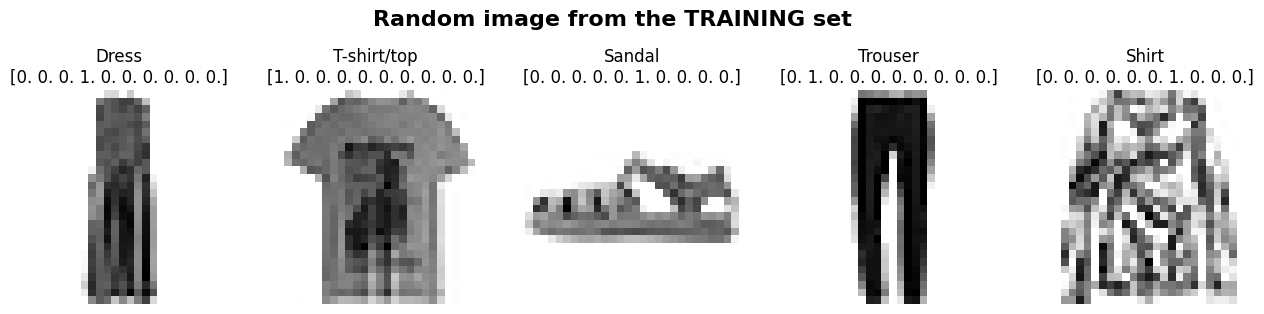

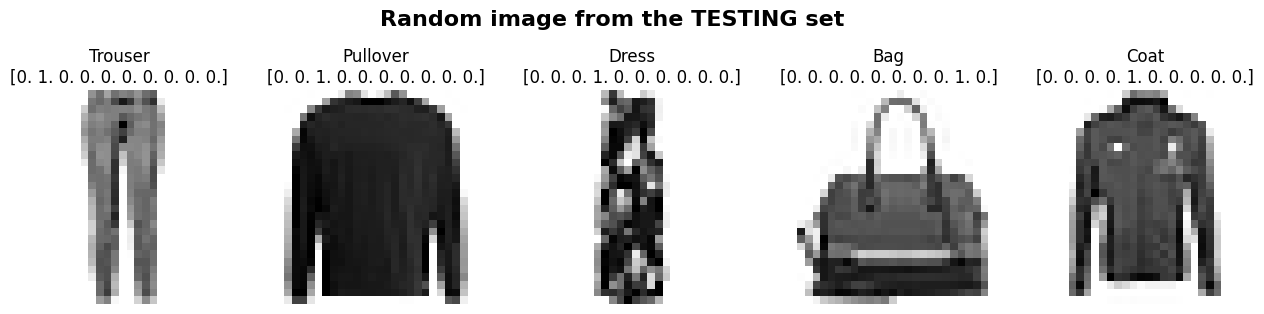

In [5]:
# Specify the PATH where the dataset is saved to.
PATH = os.path.join('data_hw2', 'fashion_mnist_npy')

# The actual meaning of the class labels.
# E.g. if an output of one-hot vector is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], it represents a Dress
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load the training input
X_train = np.load(os.path.join(PATH, 'train_data.npy'))
# Load the training labels
X_test = np.load(os.path.join(PATH, 'test_data.npy'))
# Load the testing input
Y_train = np.load(os.path.join(PATH, 'train_labels.npy'))
# Load the testing labels
Y_test = np.load(os.path.join(PATH, 'test_labels.npy'))

# Get the number of classes
num_classes = len(label_names)
# Get the number of training samples and their resolution for reshape
num_trains, HEIGHT, WIDTH = X_train.shape

# Reshape the training and testing inputs
X_train, X_test = reshape_train_data(X_train), reshape_train_data(X_test)

# Create one-hot vector for the training and testing labels
Y_train, Y_test = one_hot_vector(Y_train, num_classes), one_hot_vector(Y_test, num_classes)

# Sanity check for data and labels
fig_train, ax_train = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_train.suptitle("Random samples from the Training dataset", y=0.73, fontsize=16, fontweight='bold')

fig_test, ax_test = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_test.suptitle("Random samples from the Testing dataset", y=0.73, fontsize=16, fontweight='bold')

for idx in range(5):
    i, j = np.random.randint(num_trains), np.random.randint(X_test.shape[0])
    
    ax_train[idx].imshow(X_train[:,i].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_train[idx].set_title(label_names[np.argmax(Y_train[:,i])] + "\n" + str(Y_train[:,i]))
    ax_train[idx].axis('off')
    
    ax_test[idx].imshow(X_test[:,j].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_test[idx].set_title(label_names[np.argmax(Y_test[:,j])] + "\n" + str(Y_test[:,j]))
    ax_test[idx].axis('off')

In [6]:
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (784, 60000)
Shape of Y_train: (10, 60000)
Shape of X_test: (784, 10000)
Shape of Y_test: (10, 10000)


In [7]:
# Numbers of input units
num_inputs = X_train.shape[0]

# Amount of neurons in the hidden layers
num_hidden_1 = 9
num_hidden_2 = 3

# Numbers of output units
num_outputs = num_classes

In [8]:
def init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs):
    """Method for initializing the model parameters and the learning velocity of momentum for SGD optimizer.

    Returns:
        parameters (tuple): The model weight parameters: W1, W2, W3
        velocity (tuple): The learning velocity of momentum: V_dW1, V_dW2, V_dW3
    """
    # Initialize layer weights with random values
    W1 = np.random.randn(num_hidden_1, num_inputs)
    W2 = np.random.randn(num_hidden_2, num_hidden_1)
    W3 = np.random.randn(num_outputs, num_hidden_2)

    parameters = W1, W2, W3

    # Initialize the optimizer SGD momentum matrices
    V_dW1 = np.zeros(W1.shape)
    V_dW2 = np.zeros(W2.shape)
    V_dW3 = np.zeros(W3.shape)

    velocity = V_dW1, V_dW2, V_dW3

    return parameters, velocity

In [9]:
parameters, velocity = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

W1, W2, W3 = parameters

print('Shape of W1:', W1.shape)
print('Shape of W2:', W2.shape)
print('Shape of W3:', W3.shape)

Shape of W1: (9, 784)
Shape of W2: (3, 9)
Shape of W3: (10, 3)


The sigmoid activation is defined as:

$$
{\rm sigmoid}(x) = \frac{1}{1 + e^{-x}}
$$

The ReLU (Rectified Linear Unit) is defined as:

$$
{\rm ReLU}(x) = \text{max}(x, 0) =
\begin{cases}
x, & \text{if}\ x > 0 \\
0, & \text{otherwise}
\end{cases}
$$


The softmax activation is defined as:

$$
{\rm softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N}e^{x_j}}\ \text{for}\ i\ \text{in}\ \left\{1,...,N \right\}
$$

where $N$ is the number of classes.

In [10]:
# Define the activation functions
def sigmoid(X):
    return 1/(1+np.exp(-X))

def relu(X):
    return np.maximum(X,0)

def softmax(X):
    return (np.exp(X) / np.sum(np.exp(X), axis=0))

In [11]:
# Sanity check for the activation functions
X = np.array([-1, 0, 2]).reshape(-1, 1)

print('X')
print(X, '\n')

print('sigmoid(X):')
print(sigmoid(X), '\n')

print('relu(X):')
print(relu(X), '\n')

print('softmax(X):')
print(softmax(X))

X
[[-1]
 [ 0]
 [ 2]] 

sigmoid(x)
[[0.26894142]
 [0.5       ]
 [0.88079708]] 

relu(x)
[[0]
 [0]
 [2]] 

softmax(x)
[[0.04201007]
 [0.1141952 ]
 [0.84379473]]


Our **forward-propagation** consists of three parts:

First, we to start with the calculation of the output volume $A_1$ for the first hidden layer:

$$
\begin{cases}
Z_1 &= W_1 X \\
A_1 &= {\rm sigmoid}(Z_1) 
\end{cases}
$$

where $W_1$ is the weights of the first hidden layer, $X$ is the input, and here we use the **sigmoid** activation.


Then, we calculate the hidden volume of the second hidden layer $A_2$ by:

$$
\begin{cases}
Z_2 &= W_2 A_1 \\
A_2 &= {\rm ReLU}(Z_2) 
\end{cases}
$$

where $W_2$ is the weights of the second hidden layer, and here we use the **ReLU** activation.

Finally, we calculate the output volume of the output layer $A_3$ by:

$$
\begin{cases}
Z_3 &= W_3 A_2 \\
A_3 &= {\rm softmax}(Z_3)
\end{cases}
$$

where $W_3$ is the weights of the output layer, and here we use the softmax activation.

In this way, we get the final classification predction outputs $A_3$ from the last hidden layer.

In [13]:
def forward_propagation(X, parameters):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        parameters (tuple): Weight parameters in the model: W1, W2, W3

    Returns:
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
    """

    W1, W2, W3 = parameters
    
    Z1 = np.matmul(W1, X)
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2, A1)
    A2 = relu(Z2)
    Z3 = np.matmul(W3, A2)
    A3 = softmax(Z3)

    outputs = Z1, A1, Z2, A2, Z3, A3
    return outputs

In [14]:
# Sanity check for the forward propagation outputs
np.random.seed(1)
X = np.random.randn(num_inputs, 2)

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, parameters)

print('Shape of X:', X.shape)
print('Shape of Z1:', Z1.shape)
print('Shape of A1:', A1.shape)
print('Shape of Z2:', Z2.shape)
print('Shape of A2:', A2.shape)
print('Shape of Z3:', Z3.shape)
print('Shape of A3:', A3.shape)

print('\nExample results of A3:')
print(A3)

Shape of X: (784, 2)
Shape of Z1: (9, 2)
Shape of A1: (9, 2)
Shape of Z2: (3, 2)
Shape of A2: (3, 2)
Shape of Z3: (10, 2)
Shape of A3: (10, 2)

Example results of A3:
[[2.46725014e-03 9.30825544e-07]
 [3.31005452e-04 6.34655955e-07]
 [5.99451371e-01 9.95638430e-01]
 [9.09817956e-03 4.04817220e-03]
 [1.65653873e-01 4.63410273e-05]
 [3.01971551e-03 8.33547818e-07]
 [1.36952654e-01 3.46917061e-05]
 [6.84035576e-04 1.15346167e-05]
 [8.23364875e-02 2.18431338e-04]
 [5.42874551e-06 6.05182642e-11]]


### Loss function implementation

Here we calculate the cross entropy loss function with:


$
L = {\rm cross\_entropy}(Y, A_3) = - \frac{1}{M} \sum_{k=0}^{M} \sum_{i=0}^{N} Y_i^{k} log({A_3}_i^{k})
$


where $Y$ is the ground truth labels, $A_3$ is the prediction outputs, $N$ is the number of classes, $M$ is the number of samples in the training batch.

In [15]:
def cross_entropy_loss(Y, Y_pred):
    return -(1/Y.shape[1])*np.sum(np.multiply(Y, np.log(Y_pred)))

In [16]:
np.random.seed(1)
Y = one_hot_vector(np.random.randint(1, num_classes, 2), num_classes)
A3 = softmax(np.random.randn(num_classes, 2))

L = cross_entropy_loss(Y, A3)
print('Shape of Y:', Y.shape)
print('Shape of A3:', A3.shape)
print('Loss:', L)

Shape of Y: (10, 2)
Shape of A3: (10, 2)
Loss: 1.4200061694735258


### Backpropagation implementation

Following formulas are used to calculate the updated gradients:


$$
dZ_3 = \frac{\partial L}{\partial Z_3} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} = A_3 - Y
$$

<br>


$$
d W_3 = \frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial W_3} = \frac{1}{m} d Z_3 \cdot A_2^T
$$

Here $m$ is the number of data samples in a mini batch.

<br>



$$
d A_2 = \frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} = W_3^T \cdot (A_3 - Y)
$$

$$
\frac{\partial A_2}{\partial Z_2} = {\rm int}(A2 > 0)
$$

$$
d Z_2 = \frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} = d A_2 * {\rm int}(A2 > 0)
$$

Here ${\rm int}(A2 > 0)$ Is the Zero-One Matrix of $A2$, where values less than 1 are set to 0, and rest of the values are set to 1.

$$
d W_2 = \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} = \frac{1}{m} d Z_2 \cdot A_1^T
$$

<br>



$$
d A_1 = \frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial A_1} = W_2^T \cdot d Z_2
$$


$$
\frac{\partial A_1}{\partial Z_1} = A1 * (1 - A1)
$$

$$
d Z_1 = \frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} = d A_1 * A1 * (1 - A1)
$$

$$
d W_1 = \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} = \frac{1}{m} d Z_1 \cdot X^T
$$

<br>


In [17]:
def backward_propagation(X, Y, parameters, outputs):
    """Method for backpropagation.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
        
    Returns:
        tuple: The computed gradients: dW1, dW2, dW3     
    """

    m = X.shape[1] # The number of data samples in a mini batch

    W1, W2, W3 = parameters
    Z1, A1, Z2, A2, Z3, A3 = outputs
    
    # Calculate dW3
    dZ3 = A3 - Y
    dW3 = np.matmul(((1/m)*dZ3),A2.T)

    # Calculate dW2
    dA2 = np.matmul(W3.T,(A3-Y))
    A2[A2>0] = 1
    dZ2 = np.multiply(dA2,A2.astype(int))
    dW2 = np.matmul((1/m*dZ2),A1.T)

    # Calculate dW1
    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1*A1*(1-A1)
    dW1 = np.matmul((1/m*dZ1),X.T)

    return dW1, dW2, dW3

In [18]:
# Sanity check of backpropagation function
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))
parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)

print('Shape of dW3:', dW3.shape)
print('Shape of dW2:', dW2.shape)
print('Shape of dW1:', dW1.shape)

print('\nExample results in dW3:')
print(dW3[:, 0])

print('\nExample results in dW2:')
print(dW2[:, 0])

print('\nExample results in dW1:')
print(dW1[:, 0])

Shape of dW3: (10, 3)
Shape of dW2: (3, 9)
Shape of dW1: (9, 784)

Example results in dW3:
[-11.07686748 -11.18325156 -11.07948311 -11.15090766  -9.30689316
 -11.18940487 -11.18383374 -11.18882248 -10.89794772 -11.14887099]

Example results in dW2:
[ 9.68479859 -5.5846308   4.69322188]

Example results in dW1:
[ 1.41874064e-02 -6.39869875e-01  2.22768707e-09 -8.80866594e-07
  2.06468965e-07  6.32945305e-06 -4.88517422e-10  7.55225226e-11
  4.40379402e-03]


In [19]:
def training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda=0.):
    """Method for each training step.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        velocity (tuple): The learning velocity of momentum: V_dW1, V_dW2, V_dW3
        learning_rate (float): The learning rate for training
        beta (float): The coefficient to update the learning velocity
        weight_decay_lambda (float): The coefficient of weight decay

    Returns:
        tuple: loss, the updated parameters, the updated velocity
    """

    W1, W2, W3 = parameters

    # The forward propagation
    outputs = forward_propagation(X, parameters)
    A3 = outputs[-1]
    
    # Loss computation and backward propagation
    if weight_decay_lambda == 0.:
        loss = cross_entropy_loss(Y, A3)
        dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    else:
        loss = cross_entropy_loss(Y, A3) + weight_decay_loss(parameters, weight_decay_lambda)
        dW1, dW2, dW3 = backward_propagation_with_weight_decay(X, Y, parameters, outputs, weight_decay_lambda)
    
    V_dW1, V_dW2, V_dW3 = velocity
    
    # Updating model parameters
    V_dW1 = beta*V_dW1+(1-beta)*dW1
    V_dW2 = beta*V_dW2+(1-beta)*dW2
    V_dW3 = beta*V_dW3+(1-beta)*dW3

    W1 = W1 - learning_rate*V_dW1
    W2 = W2 - learning_rate*V_dW2
    W3 = W3 - learning_rate*V_dW3

    parameters = W1, W2, W3
    velocity = V_dW1, V_dW2, V_dW3
    
    return loss, parameters, velocity

In [20]:
def training_model(parameters, velocity, batch_size, epoch, learning_rate, beta, weight_decay_lambda=0.):
    
    # Calculate the number of training iterations base on the number of training samples and your batch size
    num_batchs = num_trains // batch_size
    print('Start training the model:')
    print('Number of training samples: {}'.format(num_trains))
    print('Number of batchs: {}'.format(num_batchs))

    loss_log = [] # Log the training loss
    
    # Training
    for i in range(epoch):    
        start_t = time.time()

        indices = np.random.permutation(num_trains)
        X_train_shuffled, Y_train_shuffled = X_train[:, indices], Y_train[:, indices]

        for j in range(num_batchs):

            # Get mini-batch samples for training
            start_idx, end_idx = j * batch_size, min(j * batch_size + batch_size, X_train.shape[1] - 1)
            X, Y = X_train_shuffled[:, start_idx : end_idx], Y_train_shuffled[:, start_idx : end_idx]

            # Call training_step()
            loss, parameters, velocity = training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda)

            loss_log.append(loss)
            if (j > 0 and j % 200 == 0):
                print("[Epoch][Iterations]:[{}/{}][{}/{}], loss: {}".format(i, epoch, j, num_batchs, loss))

        print("=> Epoch {}, elapsed time: {:.2f} seconds".format(i, time.time() - start_t))
    
    plt.title('Training loss:')
    plt.plot(loss_log)
    plt.show()
    
    return parameters

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 2.1231936897741557
[Epoch][Iterations]:[0/30][400/468], loss: 2.113513943065836
=> Epoch 0, elapsed time: 0.28 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 2.053363192843281
[Epoch][Iterations]:[1/30][400/468], loss: 2.0412284367345155
=> Epoch 1, elapsed time: 0.28 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 1.9512044208037382
[Epoch][Iterations]:[2/30][400/468], loss: 1.7525998955313495
=> Epoch 2, elapsed time: 0.27 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 1.4956463173419787
[Epoch][Iterations]:[3/30][400/468], loss: 1.369971109089457
=> Epoch 3, elapsed time: 0.27 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 1.2670844006898383
[Epoch][Iterations]:[4/30][400/468], loss: 1.1917176934003584
=> Epoch 4, elapsed time: 0.27 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 1.0948886866806111
[Epoch][Iterations]:[5/30][400/468], loss: 1

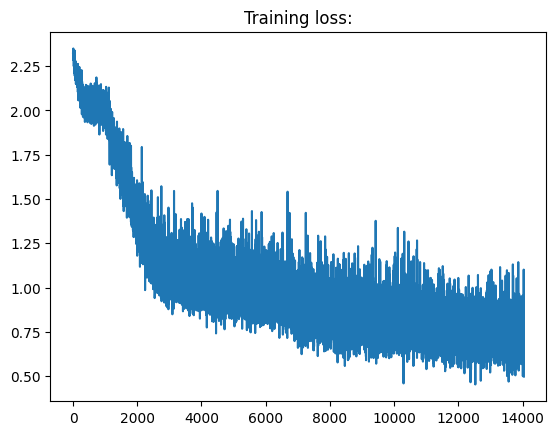

In [21]:
parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0], 
    num_hidden_1 = 9, 
    num_hidden_2 = 3,
    num_outputs = num_classes,
)

trained_parameters = training_model(
    parameters, 
    velocity,
    batch_size = 128,                                     
    epoch = 30,
    learning_rate = 0.25,                                     
    beta = 0.5,                                     
    weight_decay_lambda = 0., 
)

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
def testing_model(X, parameters):
    # Call forward_propagation() function and get the output A3
    Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, parameters)

    # Evaluate the performance of your model
    predictions = np.argmax(A3, axis=0)
    labels = np.argmax(Y_test, axis=0)

    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix(labels, predictions))
    disp.plot()
    plt.show()
    print("Testing accuracy: {}".format(accuracy_score(labels, predictions)))

Confusion Matrix:


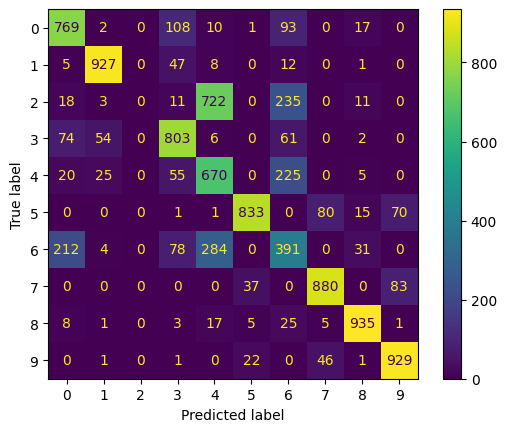

Testing accuracy: 0.7137


In [23]:
testing_model(X_test, trained_parameters)

[Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) is a set of techniques in deep learning to prevent overfitting by adding a penalty term to the loss function, discouraging overly complex models, and promoting simpler, more generalizable ones. The loss function in regularization incorporates additional terms, like L1 or L2 regularization, which penalize large weights or complex models to prevent overfitting.

To implement weight decay regularization in our neural network, we can modify the loss function as follows:

$$
L = L_1 + L_2
$$
$$
L_1 = {\rm cross\_entropy}(Y, A_3)
$$
$$
L_2 = \frac{\lambda}{2} \left( ||W_1||_2^2 + ||W_2||_2^2 + ||W_3||_2^2 \right)
$$

Here $L_2$ denotes the weight decay loss, and $||\cdot||_2^2$ is the [L2 Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)). For example, $||W_1||_2^2$ is calculated by:
$$
||W_1||_2^2 = \sum_{i=1}^{N}\sum_{j=1}^{M}{W_1^{(ij)}}^2
$$
which directly sums the squares of all elements in $W_1$.

In [24]:
def weight_decay_loss(parameters, lambd):
    """
    Args:
        parameters (tuple): Parameters in the model: W1, W2, W3
        lambd (float): The coefficient of weight decay
        m (float): The number of data samples in a mini batch
    """
    W1, W2, W3 = parameters
    # Calculate the weight decay loss
    return lambd/2*(np.sum(np.power(W1,2))+np.sum(np.power(W2,2))+np.sum(np.power(W3,2)))

In [25]:
# Sanity check for the weight_decay_loss()
np.random.seed(1)
parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

loss = weight_decay_loss(parameters, lambd=0.0001)
print('loss:', loss)

loss: 0.35471489737579914


As here we use a new loss function $L$, we need to calculate the derivative $L$ with respect to $W_1, W_2, W_3$ for backpropagation again.

Take $W_1$ as an example, the derivative of $L$ with respect to $W_1$ is calculated by: 
$$
\begin{align}
d W_{1(new)} &= \frac{\partial L}{\partial W_1} = \frac{\partial L_1}{\partial W_1} + \frac{\partial L_2}{\partial W_1} = dW_1 + \lambda W_1
\end{align}
$$


In [26]:
def backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
        lambd (float): The coefficient of weight decay

    Returns:
        tuple: The computed gradients: dW1, dW2, dW3     
    """

    W1, W2, W3 = parameters
    dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    # Calculate the updated weights
    dW1_new = dW1 + lambd*W1
    dW2_new = dW2 + lambd*W2
    dW3_new = dW3 + lambd*W3

    return dW1_new, dW2_new, dW3_new

In [27]:
# Sanity check for the updated loss function
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1_new, dW2_new, dW3_new = backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd=0.0001)

print('\nExample results in dW3 (new):')
print(dW3_new[:, 0])

print('\nExample results in dW2 (new):')
print(dW2_new[:, 0])

print('\nExample results in dW1 (new):')
print(dW1_new[:, 0])


Example results in dW3 (new):
[-11.0768454  -11.18333839 -11.07941469 -11.15094559  -9.30678255
 -11.18963176 -11.1838994  -11.18909476 -10.89788101 -11.14890796]

Example results in dW2 (new):
[ 9.68498668 -5.58462452  4.69335025]

Example results in dW1 (new):
[ 1.42425268e-02 -6.39850968e-01 -1.87264211e-05 -2.81056313e-05
  2.11108273e-04  1.11403812e-04 -3.10541295e-05  4.55282195e-05
  4.47521792e-03]


### Hyperparameter Tuning

[Hyperparameter Tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization) is an effective way to optimize the performance of neural network models in machine learning. 

For our neural network, we can adjust many hyper-parameters, such as learning rate, batch size, weight decay coefficient, training epochs, and the model architecture choices (number of neurons in hidden layers).

Start training the model:
Number of training samples: 60000
Number of batchs: 1621
[Epoch][Iterations]:[0/150][200/1621], loss: 3.3764526563892674
[Epoch][Iterations]:[0/150][400/1621], loss: 2.515515352042888
[Epoch][Iterations]:[0/150][600/1621], loss: 2.530602342632843
[Epoch][Iterations]:[0/150][800/1621], loss: 2.540257099867979
[Epoch][Iterations]:[0/150][1000/1621], loss: 2.3445669774551643
[Epoch][Iterations]:[0/150][1200/1621], loss: 2.467431027176146
[Epoch][Iterations]:[0/150][1400/1621], loss: 2.2674279685039043
[Epoch][Iterations]:[0/150][1600/1621], loss: 2.2583696353952627
=> Epoch 0, elapsed time: 1.30 seconds
[Epoch][Iterations]:[1/150][200/1621], loss: 2.268477769884601
[Epoch][Iterations]:[1/150][400/1621], loss: 2.226372602410465
[Epoch][Iterations]:[1/150][600/1621], loss: 2.0644273797269763
[Epoch][Iterations]:[1/150][800/1621], loss: 2.3585293608276636
[Epoch][Iterations]:[1/150][1000/1621], loss: 1.9807225342737138
[Epoch][Iterations]:[1/150][1200/1621], loss: 2

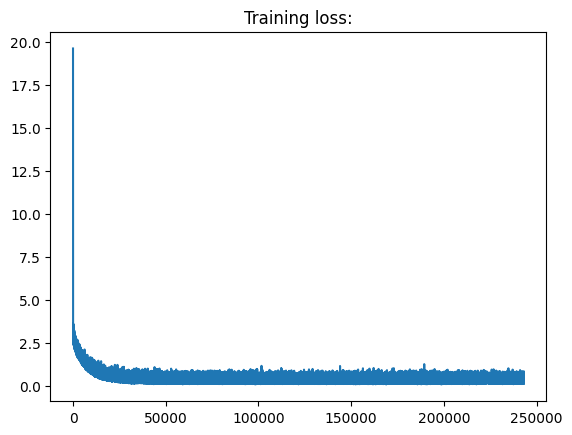

In [41]:
# We deployed automated hyperparameter tuning for the model, allowing us to find a hyperparameter combination
# yielding a model with excellent prediction accuracy (over 85%) for the MNIST Fashion testing dataset.
parameters, velocity = init_parameters(
                                    num_inputs = X_train.shape[0], 
                                    num_hidden_1 = 19, # Number of neurons in the 1st hidden layer
                                    num_hidden_2 = 27, # Number of neurons in the 2nd hidden layer
                                    num_outputs=num_classes
                                )

trained_parameters = training_model(
                                    parameters, 
                                    velocity,
                                    batch_size = 37, # Batch size of samples per training iteration
                                    epoch = 150, # Number of training epochs
                                    learning_rate = 0.25, # Learning rate                  
                                    beta = 0.55, # Loss function coefficient            
                                    weight_decay_lambda = 0.00025, # Weight Decay coefficient
                                )

Confusion Matrix:


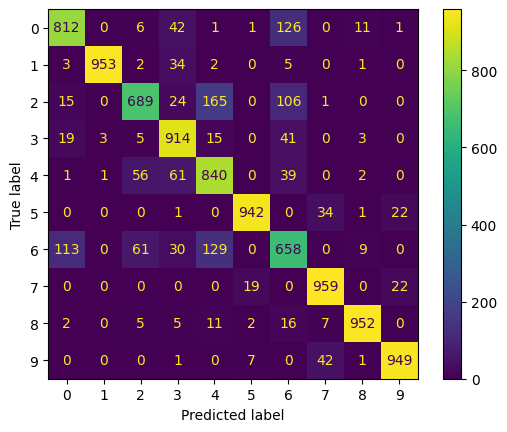

Testing accuracy: 0.8668


In [42]:
testing_model(X_test, trained_parameters)